# 2-D Bayesian mixture of distributions

This code example explores a Bayesian mixture of normal distributions in two dimensions and generates samples from it. Bayesian means that the parameters of the mixture, that is the mixing coefficients, and the mean and covariance matrix of each component follow themselves a distribution. The number of components, $K$ remains fixed.

<font color='red'> The mixing coefficients are sampled from a distribution. If that distribution is flat or uninformative, all cluster sizes are possible. That distribution can be peaked to make certain cluster sizes more likely, but there is always a non-zero possibility for any cluster size. </font>

In particular, $\boldsymbol{\pi} =(\pi_1, \ldots, \pi_K)$ follows a Dirichlet distribution with parameter $\boldsymbol{\alpha} = (\alpha/K, \ldots, \alpha/K)^T$. $\alpha$ is a hyperparamter. If it is equal to $K$, then the Dirichlet distribution is the uniform distribution and all vectors of mixing coefficients are equally likely.

<font color='red'> The distribution from which the normal distributions are drawn has four hyperparameters (hyper, since they are parameters to determine other paramters). </font>
- <font color='red'> The location vector is where the means of the sampled distributions are grouped. </font>
- <font color='red'> The inverse scale matrix is where the covariance matrices are grouped. </font>
- <font color='red'> The degrees of freedom control how similar the sampled distributions need to look to the location vector and inverse scale matrix. </font>
- <font color='red'> The mean fraction controls how overlapping the clusters are. </font>

Each normal distribution with mean $\boldsymbol{\mu}_k$ and covariance matrix $\boldsymbol{\Sigma}_k$, can be drawn from the *normal inverse Wishart distribution*, $(\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k) \sim \textrm{NIW}(\mathbf{m}, \lambda, \boldsymbol{\Psi}, \nu)$, with four hyperparameters:
- the *location vector* $\mathbf{m}$ lying in the feature space, 
- the *inverse scale matrix* $\boldsymbol{\Psi}$, which has to be symmetric and positive definite, 
- $\nu$, which has to be at least the number of dimensions $d$ of the feature space and regulates the degrees of freedom,
- the *mean fraction* $\lambda$.

## Import modules

In [1]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

## Generate samples
This is implemented as a function.

In [2]:
def BayesianMixture(size,n_components,alpha0,mean0,lambda0,scale,df):
    """ Input:
    size:           number of data points to be generated,
    n_components:   number of clusters
    alpha0:         concentration parameter,
    mean0:          location vector,
    lambda0:        mean fraction,
    scale:          scale matrix,
    df:             degrees of freedom.
    Output:
    data:           data vector,
    idx:            index vector which process generated the sample,
    p:              vector of mixing coefficients
    means:          array of the means of all processes,
    covs:           array of the covariance matrices of all processes."""
    
    # Generate vector of mixture coefficients from Dirichlet distribution given by alpha0 and n_components.
    alpha = alpha0/n_components ** np.ones(n_components)
    p= np.random.dirichlet(alpha)
    # Generate latent indicator variable for cluster membership.
    idx = np.random.choice(n_components, size=size, replace=True, p=p)
    # Allocate space for the parameters of the distributions.
    covs=np.zeros((2,2,n_components))
    means=np.zeros((2,n_components))
    # Generate distribution for each cluster.
    for k in range(n_components):
        cov=ss.invwishart.rvs(df = df, scale = scale)
        covs[:,:,k]=cov
        means[:,k]=np.random.multivariate_normal(mean = mean0, cov = 1/lambda0 * cov)    
    # Allocate space for data samples.
    data=np.zeros((size,2))
    # Generate data.
    for n in range(size):
        v=np.random.multivariate_normal(mean = means[:,idx[n]], cov = covs[:,:,idx[n]])
        data[n,:]=v
    return data, idx, p, means, covs

### Define sample size

In [3]:
sample_size = 1000

### Define hyperparameters
In this example, we use the hyperparameters, 
\begin{equation}
K = 3, \alpha = K, \mathbf{m} = \left( 0 \atop 0 \right), \lambda = 1, \boldsymbol{\Psi} = \left( 1 \atop 1.5 \right. \left.  1.5 \atop 3 \right), \nu = 6.
\end{equation}

In [4]:
K = 3
a = K
m = np.array([0, 0])
lambda0 = 1;
Psi = np.array([[1, 1.5], [1.5, 3]])
nu = 6;

### Generate distributions and samples

In [5]:
data, idx, p, means, covs = BayesianMixture(size=sample_size,n_components=K,alpha0=a,mean0=m,
                                       lambda0=lambda0,scale=Psi,df=nu)
print('Mixing coefficients: ', p, '\n')
for i in range(K):
    print('Component', i+1)
    print('Mean:', means[:,i])
    print('Covariance:', covs[:,:,i], '\n')

Mixing coefficients:  [0.09568244 0.86287168 0.04144587] 

Component 1
Mean: [-0.18880064 -0.26562961]
Covariance: [[0.13900174 0.23092905]
 [0.23092905 0.71102124]] 

Component 2
Mean: [1.10379512 1.83252216]
Covariance: [[0.73738228 1.28805913]
 [1.28805913 2.32581893]] 

Component 3
Mean: [ 0.00646713 -0.3433226 ]
Covariance: [[0.16489618 0.23632015]
 [0.23632015 0.46727373]] 



### Plot of probability density functions
#### First individually

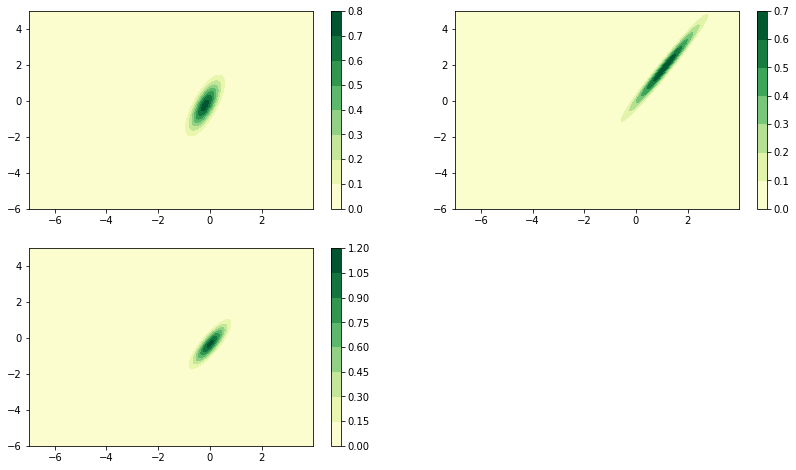

In [6]:
x, y = np.mgrid[-7:4:.01, -6:5:.01]
pos = np.dstack((x, y))
z_all = np.zeros((x.shape[0], x.shape[1]))
cols = 2.0
rows = np.ceil(K/cols)
fig = plt.figure(figsize=(14,8))
for i in range(K):
    ax = fig.add_subplot(rows, cols, i+1)
    z = ss.multivariate_normal.pdf(pos, mean = means[:,i], cov = covs[:,:,i])
    z_all = z_all + z * p[i]
    c = ax.contourf(x, y, z, cmap = plt.cm.YlGn)
    cbar = plt.colorbar(c)
plt.show()

#### Then mixed

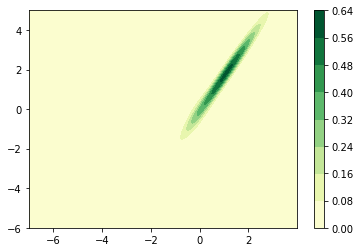

In [7]:
fig = plt.figure()
c = plt.contourf(x, y, z_all, cmap = plt.cm.YlGn)
cbar = plt.colorbar(c)
plt.show()

### Scatter plot of samples

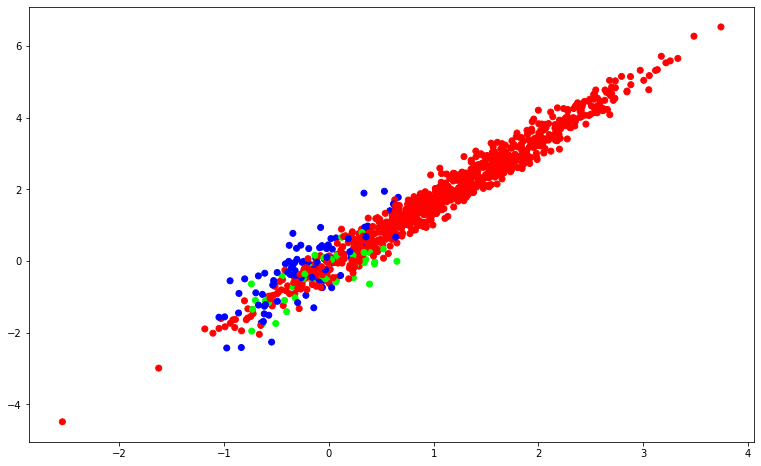

In [8]:
fig = plt.figure(figsize=(13,8))
plt.scatter(data[:,0], data[:,1], c = idx, cmap = plt.cm.brg)
plt.show()

#### Number of samples per component

In [9]:
for i in range(K):
    print('Component', i+1, ':', sum(idx==i))

Component 1 : 96
Component 2 : 854
Component 3 : 50


### Explore hyperparameters

While exploring the effect of changing one hyperparameter, keep the other ones fixed. 

First change $\alpha$ to $10 K$ and then $100 K$. You should notice that the vector of mixing coefficients becomes more like $(1/3, 1/3, 1/3)$ and the clusters become similar in size.

Next fix $\alpha = 10K$, and change the number of degrees of freedom, $\nu$, to $2$ and then $10$. You should notice that in the first case very different distributions are generated, while in the second case the distirbutions are more similar to the base distribution given by $\mathbf{m}$ and $\boldsymbol{\Psi}$

Next fix $\alpha = 10K$ and $\nu = 6$, and change the mean fraction $\lambda$ to 1/3 and then 1/5. You should notice that as $\lambda$ decreases the clusters separate.

In the next step we will infer a Bayesian mixture by adjusting the hyperparameters and sampling the parameters of the distributions.